<a href="https://colab.research.google.com/github/Rogerio-mack/IMT_CD_2025/blob/main/IMT_CD_P2_2025S1_solucao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="ITM">
</head>

<img src="https://maua.br/images/selo-60-anos-maua.svg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->




# **P2 - ECM514 Ciência de Dados**

### **Gabarito: ajuste seu dados de acordo com a prova PAR ou ÍMPAR**

### **Notas da Correção**

A prova tem que 10,0 pontos. Acesse as notas.

* **Testes de Hipóteses Q1-Q2**

> 1. Alguns alunos resolveram este exercício empregando df.sample no lugar de df. Foram considerados os resultados corretos para quaisquer dos dados.

> 2. A princípio na Q2 o **t-test** é o correto e suficiente. O teste de **levene** mostra que as variâncias não são significativamente diferentes. Mas havendo quantidades diferentes pode-se optar pelo **t-Welch** (ttest_ind com equal_var=False). Aceitei ambos, desde que aplicados corretamente, mesmo quando o aluno denominou t-test para t-Welch. O **z-test**, tratando-se de uma amostra (o caso do Titanic e que queremos inferir para outros casos), não correto, mas aceitei desde aplicado corretamente. Mas observar que para uma das provas o teste é **unilateral**.

* **Gráfico Q3**

> Sem apontamentos aqui. Gráficos próximos foram considerados 100%.

* **ARIMA Q4-Q8**

> 1. Há uma nota adicional de avaliação geral adicionada para construção geral do modelo, pois no caso do aluno errar a seleção dos dados, todos os resultados ficam comprometidos. Erros mais comuns:

>> * **Erro na seleção dos dados**: erro na seleção do intervalo de datas, erro na separação train e test, e uso da série diferenciada no modelo
>> * **Erro na interpretação ACF/PACF**
>> * **Códigos copiados empregados sem os devidos ajustes**: os mais comuns `residuals[2:-2]`,`d=[2]`, por exemplo, foram tirados de códigos exemplos das aulas, mas precisarm ter ajustado para cada caso...

* **ARIMA Q9**

> O ponto chave era verificar a ocorrências de SAZONALIDADES (não ciclos!) e que portanto é necessário empregar um modelo SARIMA (e não pode ser empredado ARIMA). Mas considerei muitos casos, exceto os que não apresentaram qualquer análise.

* **Hipótese não paramétrico Q10**

> O ponto chave é identificar que a variável numérica (o que elimina o teste Chi2, o que foi um erro comum) não tem uma distribuição normal, as quantidades diferentes, o teste requerido é um teste não paramétrico como `mannwhitneyu`.


In [ ]:
#@markdown Nome completo e RA (*\<nome\>, \<RA\>*)
Aluno = 'Daniel Henrique, 1115665' #@param {type:"string"}






In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.datasets import co2
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


# **CASO: Titanic Survivals**

Os dados do acidente do Titanic são até hoje uma das maiores fontes de dados para correlacionar fatores de sobrevivência do ser humano a desastres. Faça a análise de alguns desses fatores.






In [ ]:
df = sns.load_dataset('titanic')
# df = df.sample(frac=0.90, random_state=2)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Q1. **A classe (`pclass`) de embarque do passageiro teve influência em sua sobrevivência?**


In [ ]:
df.survived = df.survived.replace({0:'Died',1:'Survived'})
df.pclass = df.pclass.replace({1:'First',2:'Second',3:'Third'})

In [ ]:
from scipy.stats import chi2_contingency

ct = pd.crosstab(df.survived, df.pclass)
# print(ct)

chi2, p_value, dof, expected =  chi2_contingency(ct)
print(f'Chi-square statistic: {chi2:.3f}')
print(f'p-value: {p_value:.3f}')

print()
if p_value < 0.05:
	print('Rejeitamos a hipótese nula. A classe influenciou significativamente a sobrevivência.')
else:
	print('Não rejeitamos a hipótese nula. A classe não influenciou significativamente a sobrevivência.')

Chi-square statistic: 102.889
p-value: 0.000

Rejeitamos a hipótese nula. A classe influenciou significativamente a sobrevivência.


In [ ]:
from scipy.stats import chi2_contingency

ct = pd.crosstab(df.alive, df.pclass)
# print(ct)

chi2, p_value, dof, expected =  chi2_contingency(ct)
print(f'Chi-square statistic: {chi2:.3f}')
print(f'p-value: {p_value:.3f}')

print()
if p_value < 0.05:
	print('Rejeitamos a hipótese nula. A classe influenciou significativamente a sobrevivência.')
else:
	print('Não rejeitamos a hipótese nula. A classe não influenciou significativamente a sobrevivência.')

Chi-square statistic: 102.889
p-value: 0.000

Rejeitamos a hipótese nula. A classe influenciou significativamente a sobrevivência.


## Q2. **Pelos dados, a idade do passageiro parece ter influência em sua sobrevivência?** (se necessário, exclua casos com idade ausente)


In [ ]:
from scipy.stats import levene

age_survived = df[df.survived == 'Survived'].age.dropna()
age_died = df[df.survived == 'Died'].age.dropna()

# Perform Levene's test for equality of variances
stat, p_value = levene(age_survived, age_died)

print(f"Levene's test statistic: {stat:.3f}")
print(f"p-value: {p_value:.3f}")

if p_value < 0.05:
    print("Rejeitamos a hipótese nula: as variâncias das idades nos grupos 'Survived' e 'Died' são significativamente diferentes.")
else:
    print("Não rejeitamos a hipótese nula: não há evidência suficiente para afirmar que as variâncias das idades nos grupos 'Survived' e 'Died' são significativamente diferentes.")

Levene's test statistic: 1.195
p-value: 0.275
Não rejeitamos a hipótese nula: não há evidência suficiente para afirmar que as variâncias das idades nos grupos 'Survived' e 'Died' são significativamente diferentes.


In [ ]:
from scipy.stats import ttest_ind

df = df.dropna(subset=['age'])

t_stat, p_value = ttest_ind(df[df.survived == 'Survived'].age, df[df.survived == 'Died'].age,equal_var=False)

print("Resultados do Teste t de Student:")
print(f"Estatística t: {t_stat:.3f}")
print(f"p-valor: {p_value:.3f}")
print()

if p_value < 0.05:
    print("Rejeitamos a hipótese nula. A idade influenciou significativamente a sobrevivência.")
else:
    print("Não rejeitamos a hipótese nula. A idade não influenciou significativamente a sobrevivência.")


Resultados do Teste t de Student:
Estatística t: -2.046
p-valor: 0.041

Rejeitamos a hipótese nula. A idade influenciou significativamente a sobrevivência.


In [ ]:
from statsmodels.stats.weightstats import ztest

# Realizar o Z-test
z_stat, p_value_ztest = ztest(df[df.survived == 'Survived'].age, df[df.survived == 'Died'].age, value=0) # value=0 para testar se a diferença das médias é 0

print("\nResultados do Z-test:")
print(f"Estatística z: {z_stat:.3f}")
print(f"p-valor: {p_value_ztest:.3f}")
print()

if p_value_ztest < 0.05:
    print("Rejeitamos a hipótese nula. A média de idade é significativamente diferente entre os sobreviventes e não sobreviventes.")
else:
    print("Não rejeitamos a hipótese nula. A média de idade não é significativamente diferente entre os sobreviventes e não sobreviventes.")


Resultados do Z-test:
Estatística z: -2.067
p-valor: 0.039

Rejeitamos a hipótese nula. A média de idade é significativamente diferente entre os sobreviventes e não sobreviventes.


## Q2. **É significativamente menor (média) a idade dos passageiros sobreviventes que os não sobreviventes?** (se necessário, exclua casos com idade ausente)


In [ ]:
from scipy.stats import levene

age_survived = df[df.survived == 'Survived'].age.dropna()
age_died = df[df.survived == 'Died'].age.dropna()

# Perform Levene's test for equality of variances
stat, p_value = levene(age_survived, age_died)

print(f"Levene's test statistic: {stat:.3f}")
print(f"p-value: {p_value:.3f}")

if p_value < 0.05:
    print("Rejeitamos a hipótese nula: as variâncias das idades nos grupos 'Survived' e 'Died' são significativamente diferentes.")
else:
    print("Não rejeitamos a hipótese nula: não há evidência suficiente para afirmar que as variâncias das idades nos grupos 'Survived' e 'Died' são significativamente diferentes.")

Levene's test statistic: 1.195
p-value: 0.275
Não rejeitamos a hipótese nula: não há evidência suficiente para afirmar que as variâncias das idades nos grupos 'Survived' e 'Died' são significativamente diferentes.


In [ ]:
t_stat, p_value = ttest_ind(df[df.survived == 'Survived'].age, df[df.survived == 'Died'].age, equal_var=False, alternative='less')

print("Resultados do Teste t de Student (Alternative: less):")
print(f"Estatística t: {t_stat:.3f}")
print(f"p-valor: {p_value:.3f}")
print()

if p_value < 0.05:
    print("Rejeitamos a hipótese nula. A idade dos sobreviventes é significativamente menor que a dos não sobreviventes.")
else:
    print("Não rejeitamos a hipótese nula. A idade dos sobreviventes não é significativamente menor que a dos não sobreviventes.")

Resultados do Teste t de Student (Alternative: less):
Estatística t: -2.046
p-valor: 0.021

Rejeitamos a hipótese nula. A idade dos sobreviventes é significativamente menor que a dos não sobreviventes.


In [ ]:
t_stat, p_value = ttest_ind(df[df.survived == 'Survived'].age, df[df.survived == 'Died'].age, alternative='less')

print("Resultados do Teste t de Student (Alternative: less):")
print(f"Estatística t: {t_stat:.3f}")
print(f"p-valor: {p_value:.3f}")
print()

if p_value < 0.05:
    print("Rejeitamos a hipótese nula. A idade dos sobreviventes é significativamente menor que a dos não sobreviventes.")
else:
    print("Não rejeitamos a hipótese nula. A idade dos sobreviventes não é significativamente menor que a dos não sobreviventes.")

Resultados do Teste t de Student (Alternative: less):
Estatística t: -2.067
p-valor: 0.020

Rejeitamos a hipótese nula. A idade dos sobreviventes é significativamente menor que a dos não sobreviventes.


# **CASE: US House Sales**



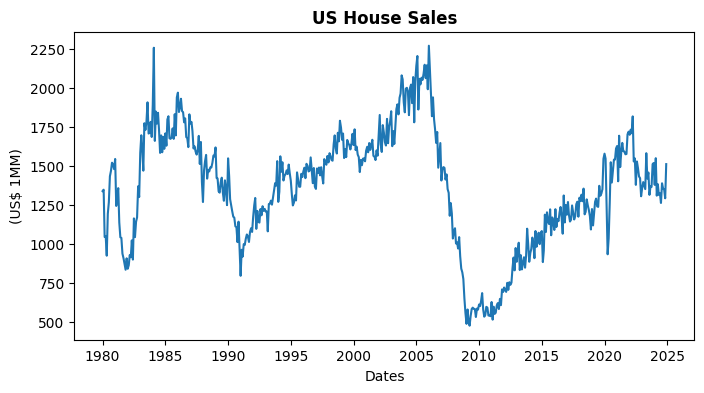

In [ ]:
import pandas_datareader as pdr

reader = pdr.fred.FredReader(["HOUST"], start="1980-01-01", end="2024-12-01")
data = reader.read()
housing = data.HOUST
housing.index.freq = housing.index.inferred_freq

fig = plt.figure(figsize=(8, 4))
plt.plot(housing)
plt.title('US House Sales',weight='bold')
plt.xlabel('Dates')
plt.ylabel('(US$ 1MM)')
plt.show()


## Q3. Produza um gráfico como abaixo

Na economia encontramos muitos *ciclos* representados por perídos de crescimento, uma queda, e um novo ciclo. Faça um gráfico para delimitar e exibir um ciclo do seu início ao final da fase de crescimento.

Crie uma função,

```
plot_interval1(data_inicio_min, data_fim_min, data_inicio_max, data_fim_max)
```

Que dado dois intervalos de data, localiza o valor mínimo (do primeiro intervalo)  e o máximo (do segundo intervalo) delimitando esses valores no gráfico como abaixo.

Produza o gráfico o mais semelhante possível. A proporção entre os dois gráficos é 2:1 (largura).



In [ ]:
df = housing.copy()

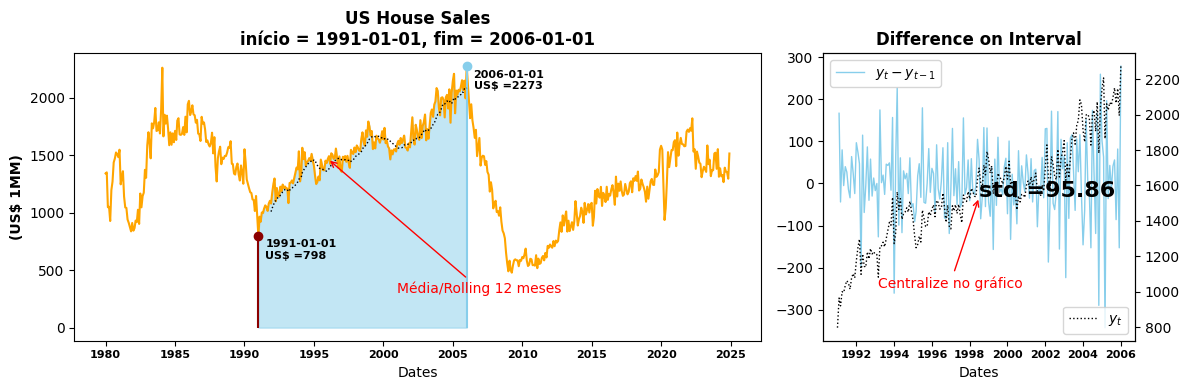

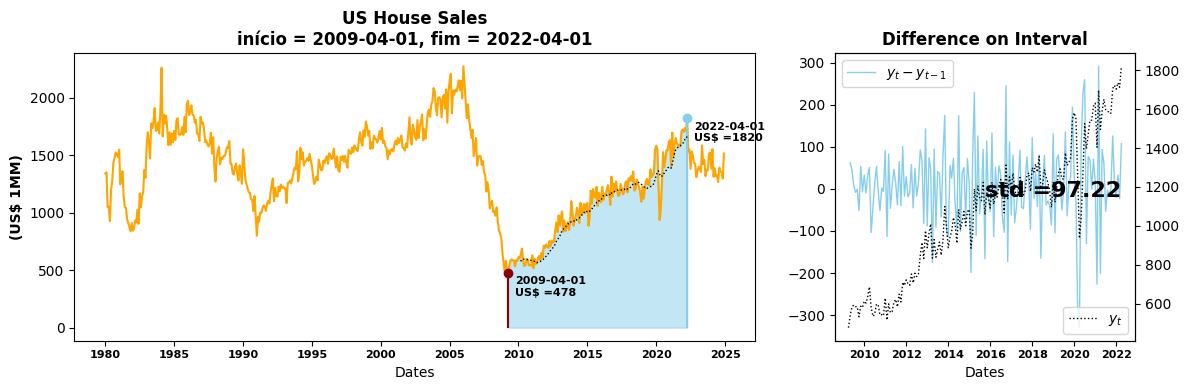

In [ ]:
def plot_interval1(data_inicio_min, data_fim_min, data_inicio_max, data_fim_max):
  fig = plt.figure(figsize=(12, 4))

  ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2) # First subplot takes 2 columns out of 3
  ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1) # Second subplot takes 1 column out of 3

  a = df[(df.index > data_inicio_min) & (df.index < data_fim_min)].idxmin()
  b = df[(df.index > data_inicio_max) & (df.index < data_fim_max)].idxmax()

  ax1.plot(df, color='orange')
  ax1.set_title(f'US House Sales\ninício = {str(a)[0:10]}, fim = {str(b)[0:10]}',weight='bold')
  ax1.set_xlabel('Dates')
  ax1.set_ylabel('(US$ 1MM)',weight='bold')

  ax1.vlines(a, 0, df.loc[a], color='darkred')
  ax1.vlines(b, 0, df.loc[b], color='skyblue')

  ax1.plot(a, df.loc[a], marker='o', color='darkred')
  ax1.plot(b, df.loc[b], marker='o', color='skyblue')

  ax1.text(a + pd.DateOffset(months=6), df.loc[a] - 200, str(a)[0:10] + '\nUS$ =' + str(df.loc[a]), fontsize=8, weight='bold')
  ax1.text(b + pd.DateOffset(months=6), df.loc[b] - 200, str(b)[0:10] + '\nUS$ =' + str(df.loc[b]), fontsize=8, weight='bold')
  ax1.fill_between(df.index, df, where=(df.index >= a) & (df.index <= b), color='skyblue', alpha=0.5)

  ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(),fontsize=8,weight='bold')

  ax1.plot(df[(df.index >= a) & (df.index <= b)].rolling(12).mean(),color='black',linestyle=':',linewidth=1)

  ax3 = ax2.twinx()

  ax2.plot(df[(df.index >= a) & (df.index <= b)].diff().dropna(), color='skyblue' , label='$y_t - y_{t-1}$',linewidth=1)
  ax2.set_title('Difference on Interval',weight='bold')
  ax2.set_xlabel('Dates')
  ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(),fontsize=8,weight='bold')
  ax2.legend(loc='upper left',fontsize=10)

  xmin, xmax = ax2.get_xlim()
  ymin, ymax = ax2.get_ylim()
  ax2.text(a + (b - a)/2, (ymax + ymin)/2, 'std =' + str(np.round(df[(df.index >= a) & (df.index <= b)].diff().dropna().std(),2)),fontsize=16, weight='bold')

  ax3.plot(df[(df.index >= a) & (df.index <= b)],color='black',linestyle=':',linewidth=1, label='$y_t$')
  ax3.legend(loc='lower right',fontsize=10)

  # você não precisa disso
  xmin, xmax = ax3.get_xlim()
  ymin, ymax = ax3.get_ylim()
  ax3.annotate('Centralize no gráfico',
              xy = (a + (b - a)/2, (ymax + ymin)/2),
              xytext = (a + (b - a)/7, (ymax + ymin)/3),
              arrowprops=dict(arrowstyle="->",color='red'),
              color = 'red')

  ax1.annotate('Média/Rolling 12 meses',
              xy = (pd.to_datetime('1996-01-01'), df.loc['1996-01-01']),
              xytext = (pd.to_datetime('2001-01-01'), 300),
              arrowprops=dict(arrowstyle="->",color='red'),
              color = 'red')

  plt.tight_layout()
  plt.show()

  return

def plot_interval(data_inicio_min, data_fim_min, data_inicio_max, data_fim_max):
  fig = plt.figure(figsize=(12, 4))

  ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2) # First subplot takes 2 columns out of 3
  ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1) # Second subplot takes 1 column out of 3

  a = df[(df.index > data_inicio_min) & (df.index < data_fim_min)].idxmin()
  b = df[(df.index > data_inicio_max) & (df.index < data_fim_max)].idxmax()

  ax1.plot(df, color='orange')
  ax1.set_title(f'US House Sales\ninício = {str(a)[0:10]}, fim = {str(b)[0:10]}',weight='bold')
  ax1.set_xlabel('Dates')
  ax1.set_ylabel('(US$ 1MM)',weight='bold')

  ax1.vlines(a, 0, df.loc[a], color='darkred')
  ax1.vlines(b, 0, df.loc[b], color='skyblue')

  ax1.plot(a, df.loc[a], marker='o', color='darkred')
  ax1.plot(b, df.loc[b], marker='o', color='skyblue')

  ax1.text(a + pd.DateOffset(months=6), df.loc[a] - 200, str(a)[0:10] + '\nUS$ =' + str(df.loc[a]), fontsize=8, weight='bold')
  ax1.text(b + pd.DateOffset(months=6), df.loc[b] - 200, str(b)[0:10] + '\nUS$ =' + str(df.loc[b]), fontsize=8, weight='bold')
  ax1.fill_between(df.index, df, where=(df.index >= a) & (df.index <= b), color='skyblue', alpha=0.5)

  ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(),fontsize=8,weight='bold')

  ax1.plot(df[(df.index >= a) & (df.index <= b)].rolling(12).mean(),color='black',linestyle=':',linewidth=1)

  ax3 = ax2.twinx()

  ax2.plot(df[(df.index >= a) & (df.index <= b)].diff().dropna(), color='skyblue' , label='$y_t - y_{t-1}$',linewidth=1)
  ax2.set_title('Difference on Interval',weight='bold')
  ax2.set_xlabel('Dates')
  ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(),fontsize=8,weight='bold')
  ax2.legend(loc='upper left',fontsize=10)

  xmin, xmax = ax2.get_xlim()
  ymin, ymax = ax2.get_ylim()
  ax2.text(a + (b - a)/2, (ymax + ymin)/2, 'std =' + str(np.round(df[(df.index >= a) & (df.index <= b)].diff().dropna().std(),2)),fontsize=16, weight='bold')

  ax3.plot(df[(df.index >= a) & (df.index <= b)],color='black',linestyle=':',linewidth=1, label='$y_t$')
  ax3.legend(loc='lower right',fontsize=10)

  plt.tight_layout()
  plt.show()

  return

plot_interval1('1985-01-01', '1999-01-01', '1985-01-01', '2010-01-01')

plot_interval('2005-01-01', '2010-01-01', '2022-01-01', '2023-01-01')



## Q4. Modelo ARIMA

Considere os dados de crescimento do 1o ciclo (**1991-01-01 a 2006-01-01**). Determine os parâmetros p,d,q do modelo ARIMA (pode empregar todos os dados do intervalo desses dados). **Ao analisar os gráficos PACF e ACF, empregue valores de p e q sempre não superiores a 3**.


1991-01-01 00:00:00 2006-01-01 00:00:00


,HOUST
DATE,
1991-01-01,798
1991-02-01,965
1991-03-01,921
1991-04-01,1001
1991-05-01,996


,HOUST
DATE,
2005-09-01,2151
2005-10-01,2065
2005-11-01,2147
2005-12-01,1994
2006-01-01,2273


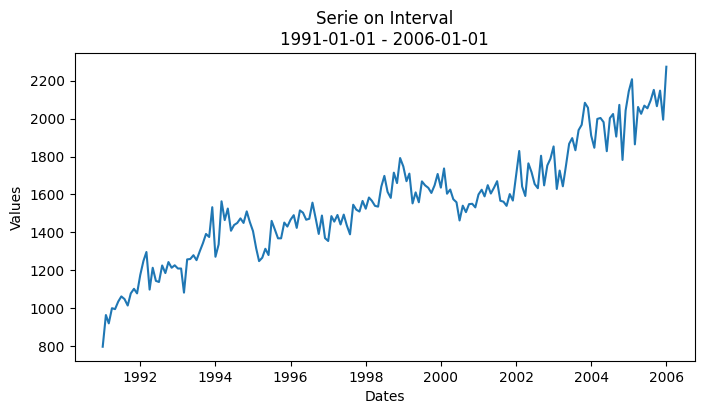

In [ ]:
data_inicio_min, data_fim_min, data_inicio_max, data_fim_max  = '1985-01-01', '1999-01-01', '1985-01-01', '2010-01-01'
# data_inicio_min, data_fim_min, data_inicio_max, data_fim_max  = '2005-01-01', '2010-01-01', '2022-01-01', '2023-01-01'
a = df[(df.index > data_inicio_min) & (df.index < data_fim_min)].idxmin()
b = df[(df.index > data_inicio_max) & (df.index < data_fim_max)].idxmax()
print(a,b)

ts = df[(df.index >= a) & (df.index <= b)]
display(ts.head())
display(ts.tail())

fig = plt.figure(figsize=(8, 4))

plt.plot(ts)
plt.title(f'Serie on Interval\n{str(a)[0:10]} - {str(b)[0:10]}')
plt.xlabel('Dates')
plt.ylabel('Values')
plt.show()

### Teste de estacionariedade (Dickey-Fuller Aumentado - ADF), **$d$**



In [ ]:
def adf_test(series):
    result = adfuller(series)
    print('Teste ADF:')
    print(f'Estatística ADF: {result[0]}')
    print(f'Valor-p: {result[1]}')
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print('A série temporal é estacionária (rejeita H0)')
    else:
        print('A série temporal não é estacionária (falha em rejeitar H0)')
    return result[1]

adf_result = adf_test(ts)

Teste ADF:
Estatística ADF: -0.9842602441338271
Valor-p: 0.7589616406581461
Valores Críticos:
	1%: -3.467845319799907
	5%: -2.878011745497439
	10%: -2.575551186759871
A série temporal não é estacionária (falha em rejeitar H0)


In [ ]:
adf_test(ts.diff().dropna())

Teste ADF:
Estatística ADF: -12.07847512424261
Valor-p: 2.2610796893858427e-22
Valores Críticos:
	1%: -3.467845319799907
	5%: -2.878011745497439
	10%: -2.575551186759871
A série temporal é estacionária (rejeita H0)


np.float64(2.2610796893858427e-22)

Teste ADF:
Estatística ADF: -12.07847512424261
Valor-p: 2.2610796893858427e-22
Valores Críticos:
	1%: -3.467845319799907
	5%: -2.878011745497439
	10%: -2.575551186759871
A série temporal é estacionária (rejeita H0)


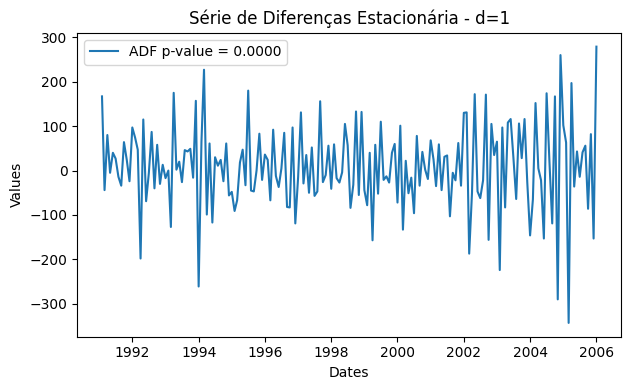

In [ ]:
plt.figure(figsize=(12,4))

ts_diff = ts.diff().dropna()
plt.subplot(1, 2, 1)
plt.plot(ts_diff, label = f'ADF p-value = {adf_test(ts_diff):.4f}')
plt.title('Série de Diferenças Estacionária - d=1')
plt.xlabel('Dates')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

### Auto-correlação e Correlação Parcial, ACF e PACF, **$q, p$**



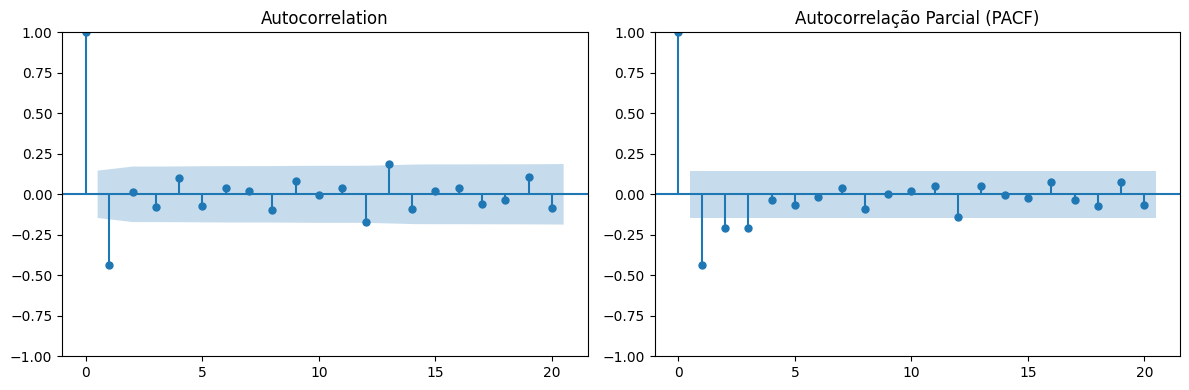

In [ ]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(12, 4))

plot_acf(ts_diff, lags=20, ax=ax1)
ax2.set_title('Autocorrelação (ACF)')

plot_pacf(ts_diff, lags=20, ax=ax2)
ax2.set_title('Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()



## Q5. Forecast

Aplique o modelo obtido para prever as 3 três últimas datas (conjunto de teste) do intervalo selecionado dos dados. Qual o valor previsto da última data de teste?   



$$ARIMA(3,1,1)(0,0,0,0)$$
$$ARIMA(1,1,1)(0,0,0,0)$$

In [ ]:
train, test = ts.iloc[0:-3], ts.iloc[-3::]

display(train.tail())
display(test.head())

,HOUST
DATE,
2005-06-01,2068
2005-07-01,2054
2005-08-01,2095
2005-09-01,2151
2005-10-01,2065


,HOUST
DATE,
2005-11-01,2147
2005-12-01,1994
2006-01-01,2273


                               SARIMAX Results                                
Dep. Variable:                  HOUST   No. Observations:                  178
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1030.088
Date:                Tue, 24 Jun 2025   AIC                           2070.176
Time:                        15:13:11   BIC                           2086.056
Sample:                    01-01-1991   HQIC                          2076.616
                         - 10-01-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4891      0.377     -1.297      0.195      -1.228       0.250
ar.L2         -0.2798      0.191     -1.466      0.143      -0.654       0.094
ar.L3         -0.1783      0.091     -1.953      0.0

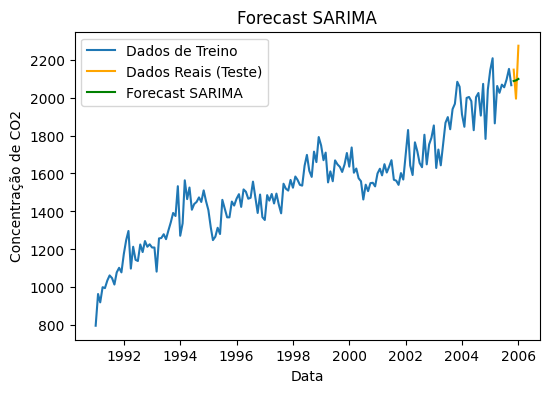

2005-11-01    2087.053439
2005-12-01    2090.339744
2006-01-01    2097.900762
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
order = (3,1,1)              # (p, d, q) não-sazonal
# seasonal_order = (0, 0, 0, 0) # (P, D, Q, s) sazonal

# Treinar o modelo SARIMA
# model = ARIMA(train, order=order, seasonal_order=seasonal_order)
model = ARIMA(train, order=order)
model_fit = model.fit()

print(model_fit.summary())

# Fazer o forecast
forecast_steps = len(test)

# forecast = model_fit.forecast(steps=forecast_steps) # Esta é a forma antiga
# Usar predict para um forecast mais robusto com índices
forecast = model_fit.predict(start=test.index[0], end=test.index[-1])

# Visualizar o forecast
plt.figure(figsize=(6,4))
plt.plot(train.index, train, label='Dados de Treino')
plt.plot(test.index, test, label='Dados Reais (Teste)', color='orange')
plt.plot(test.index, forecast, label='Forecast SARIMA', color='green')
plt.title('Forecast SARIMA')
plt.xlabel('Data')
plt.ylabel('Concentração de CO2')
plt.legend()
plt.show()

print(forecast)


## Q6. Análise dos Resíduos

Faça quaisquer dos testes estudados e verifique a normalidade dos resíduos.

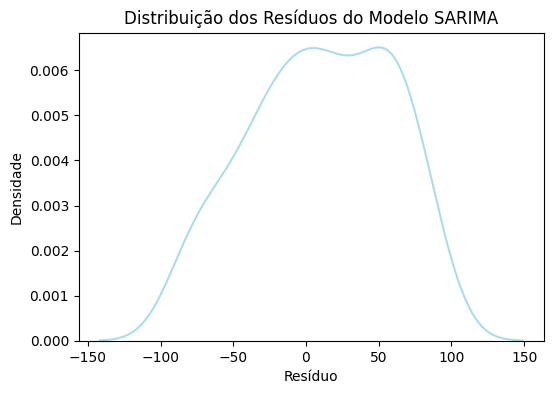

In [ ]:
residuals = model_fit.resid

plt.figure(figsize=(6, 4))
sns.kdeplot(residuals[ np.abs(residuals) < 100 ], alpha=0.7, color='skyblue')
plt.title('Distribuição dos Resíduos do Modelo SARIMA')
plt.xlabel('Resíduo')
plt.ylabel('Densidade')
# plt.xlim(-30, 30)

plt.show()

<Figure size 600x400 with 0 Axes>

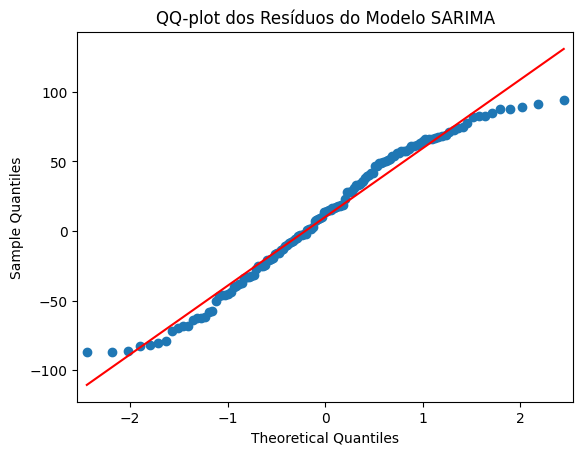

In [ ]:
from statsmodels.graphics.api import qqplot
from matplotlib import pyplot

# Gerar o QQ-plot dos resíduos
plt.figure(figsize=(6,4))
qqplot(residuals[ np.abs(residuals) < 100 ], line='r')
plt.title('QQ-plot dos Resíduos do Modelo SARIMA')
pyplot.show()

### Testes de normalidade do erro

In [ ]:
from scipy.stats import jarque_bera

# Teste de Jarque-Bera
# H₀ (nula): os resíduos têm distribuição normal.
jb_stat, jb_pvalue = jarque_bera(residuals[~np.isnan(residuals)])

print(f'Teste de Jarque-Bera para Normalidade dos Resíduos:')
print(f'Estatística de teste: {jb_stat:.3f}')
print(f'Valor-p: {jb_pvalue:.3f}')
if jb_pvalue > 0.05:
    print('Os resíduos parecem ser normalmente distribuídos (não rejeitar H0)')
else:
    print('Os resíduos não parecem ser normalmente distribuídos (rejeita H0)')

Teste de Jarque-Bera para Normalidade dos Resíduos:
Estatística de teste: 3089.137
Valor-p: 0.000
Os resíduos não parecem ser normalmente distribuídos (rejeita H0)


In [ ]:
from scipy.stats import shapiro

# Teste de Shapiro-Wilk
# H₀ (nula): os resíduos têm distribuição normal.
sw_stat, sw_pvalue = shapiro(residuals[~np.isnan(residuals)])

print(f'Teste de Shapiro-Wilk para Normalidade dos Resíduos:')
print(f'Estatística de teste: {sw_stat:.3f}')
print(f'Valor-p: {sw_pvalue:.3f}')
if sw_pvalue > 0.05:
    print('Os resíduos parecem ser normalmente distribuídos (não rejeitar H0)')
else:
    print('Os resíduos não parecem ser normalmente distribuídos (rejeita H0)')


Teste de Shapiro-Wilk para Normalidade dos Resíduos:
Estatística de teste: 0.837
Valor-p: 0.000
Os resíduos não parecem ser normalmente distribuídos (rejeita H0)


### Correlação dos resíduos

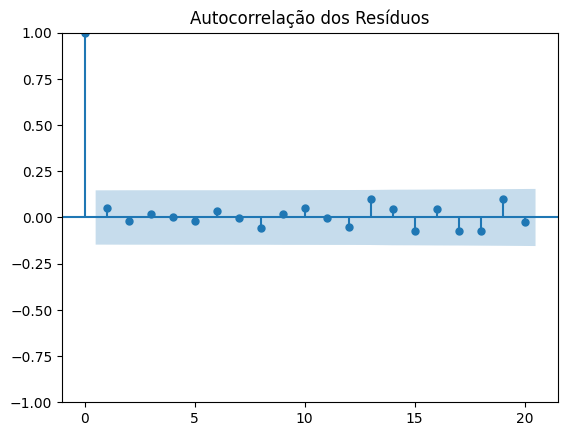

In [ ]:
# Testar a autocorrelação dos resíduos (idealmente, os resíduos não devem ser correlacionados)
plot_acf(residuals, lags=20)
plt.title('Autocorrelação dos Resíduos')
plt.show()

## Q7. Análise do Erro

Qual a raiz do erro médio quadrático e o percentual de erro das predições sobre o conjunto de teste e de treinamento?

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calcular o RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f'RMSE do conjunto de teste: {rmse:.2f}')

mape = np.mean(np.abs(test - forecast) / test) * 100
print(f'MAPE do conjunto de teste: {mape:.2f} %')

# Calcular o RMSE
rmse = sqrt(mean_squared_error(train[1::], model_fit.fittedvalues[1::]))
print(f'RMSE do conjunto de treinamento: {rmse:.2f}')

mape = np.mean(np.abs(train[1::] - model_fit.fittedvalues[1::]) / train[1::]) * 100
print(f'MAPE do conjunto de treinamento: {mape:.2f} %')

RMSE do conjunto de teste: 120.46
MAPE do conjunto de teste: 5.11 %
RMSE do conjunto de treinamento: 81.68
MAPE do conjunto de treinamento: 4.19 %


## Q8. Seleção de Modelos para vários parâmetros

Varie os parâmetros do ARIMA (máx 4) e verifique os melhores parâmetros de acordo com o AIC do modelo.

In [ ]:
import itertools
from sklearn.metrics import mean_squared_error

# Definir os ranges para p e q (d é fixo em 2, pois a série diferenciada é estacionária)
p = range(0, 4)
d = [1]
q = range(0, 4)
# d é 1 baseado na análise ADF da série diferenciada

# Combinar os parâmetros em uma lista de tuplas (p, d, q)
pdq = list(itertools.product(p, d, q))

# Armazenar resultados (AIC e RMSE)
results = []

# Iterar sobre todas as combinações de (p, d, q)
for param in pdq:
  try:
    model = ARIMA(train, order=param)
    model_fit = model.fit()

    # Calcular o AIC
    aic = model_fit.aic

    # Fazer o forecast para calcular o RMSE
    forecast_steps = len(test)
    forecast = model_fit.predict(start=test.index[0], end=test.index[-1])

    # Calcular o RMSE
    rmse = np.sqrt(mean_squared_error(test, forecast))

    # Armazenar os resultados
    results.append({'order': param, 'AIC': aic, 'RMSE': rmse})

  except:
    # Em caso de erro na convergência do modelo, pular para a próxima combinação
    print(f"Não foi possível treinar o modelo com order={param}")
    continue

# Exibir os resultados
results_df = pd.DataFrame(results)
print("\nResultados da variação dos parâmetros SARIMA:")
print(results_df.sort_values(by='AIC')) # Ordenar por AIC para ver os melhores modelos

# Opcional: Encontrar o modelo com o menor AIC
best_model_aic = results_df.loc[results_df['AIC'].idxmin()]
print("\nMelhor modelo baseado no menor AIC:")
print(best_model_aic)

# Opcional: Encontrar o modelo com o menor RMSE
best_model_rmse = results_df.loc[results_df['RMSE'].idxmin()]
print("\nMelhor modelo baseado no menor RMSE:")
print(best_model_rmse)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Resultados da variação dos parâmetros SARIMA:
        order          AIC        RMSE
11  (2, 1, 3)  2064.070470  130.641107
15  (3, 1, 3)  2065.069283  129.417502
1   (0, 1, 1)  2065.585081  124.739039
2   (0, 1, 2)  2067.584921  124.710358
5   (1, 1, 1)  2067.584932  124.712602
12  (3, 1, 0)  2068.184337  120.324123
6   (1, 1, 2)  2069.363755  124.744555
3   (0, 1, 3)  2069.507408  124.574953
9   (2, 1, 1)  2069.519726  124.760854
13  (3, 1, 1)  2070.175593  120.463936
7   (1, 1, 3)  2071.132964  125.474386
10  (2, 1, 2)  2071.212194  125.350586
14  (3, 1, 2)  2071.813923  122.295669
8   (2, 1, 0)  2072.762441  124.662609
4   (1, 1, 0)  2078.991500  119.960408
0   (0, 1, 0)  2110.939083  135.436332

Melhor modelo baseado no menor AIC:
order     (2, 1, 3)
AIC      2064.07047
RMSE     130.641107
Name: 11, dtype: object

Melhor modelo baseado no menor RMSE:
order     (1, 1, 0)
AIC       2078.9915
RMSE     119.960408
Name: 4, dtype: object


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# **CASE: Sun Spots**


## Q9. ARIMA?

Considere a série de dados de número de explosões/manchas solares observáveis. Podemos empregar um modelo ARIMA para a predição desta série de dados? Justifique suas resposta fazendo e apresentando sua análise dos dados.  

> **Faça um texto comentando suas células de código e justificando as suas análises.**

In [2]:
import statsmodels as sm
df = sm.datasets.sunspots.load_pandas().data
df.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


In [5]:
df.set_index('YEAR', inplace=True)
df.head()

,SUNACTIVITY
YEAR,
1700.0,5.0
1701.0,11.0
1702.0,16.0
1703.0,23.0
1704.0,36.0


In [6]:
df.index = pd.to_datetime(df.index, format='%Y')
df.head()

,SUNACTIVITY
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


Exploração da Série, Decomposição

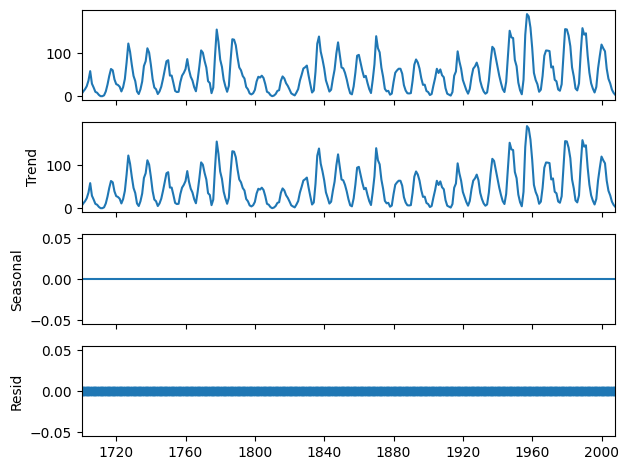

In [7]:
decomposition = seasonal_decompose(df)

fig = decomposition.plot()
plt.show()

Teste de estacionariedade (Dickey-Fuller Aumentado - ADF)

In [10]:
def adf_test(series):
    result = adfuller(series)
    print('Teste ADF:')
    print(f'Estatística ADF: {result[0]}')
    print(f'Valor-p: {result[1]}')
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print('A série temporal é estacionária (rejeita H0)')
    else:
        print('A série temporal não é estacionária (falha em rejeitar H0)')
    return result[1]

adf_result = adf_test(df.diff().dropna())

Teste ADF:
Estatística ADF: -14.861663428129381
Valor-p: 1.715552423167157e-27
Valores Críticos:
	1%: -3.4523371197407404
	5%: -2.871222860740741
	10%: -2.571929211111111
A série temporal é estacionária (rejeita H0)


Auto-correlação e Correlação Parcial, ACF e PACF



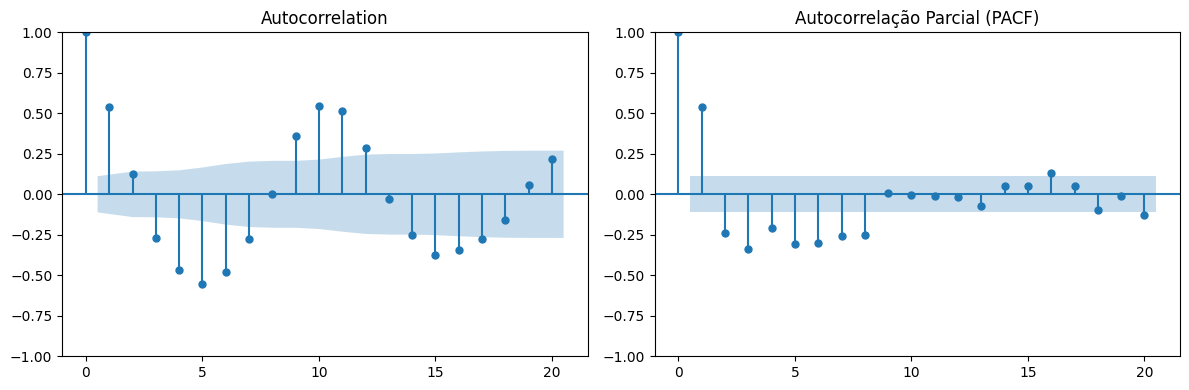

In [11]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(12, 4))

plot_acf(df.diff().dropna(), lags=20, ax=ax1)
ax2.set_title('Autocorrelação (ACF)')

plot_pacf(df.diff().dropna(), lags=20, ax=ax2)
ax2.set_title('Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()



Os gráficos acima em particular o ACF mostra um comportamento sazonal não sendo suficiente um modelo ARIMA(p,d,q), pois requer um modelo que modele sazonalidades como o SARIMA(p,d,q)(P,D,Q,m).

# **CASE: Game Analysis**

Um pesquisador está investigando a experiência de usuários em um jogo com diferentes dispositivos. Para isso ele selecionou alguns alunos da Universidade para testar os jogos. Cada jogador responde um questionário prévio com informações do seu perfil, realiza uma ou até 3 jogadas com os dispositivos *Skate*, *Joystick* e *Teclado*. Após as jogadas com cada dispositivo ele responde um questionário padrão de experiência do usuário cujo o resultado já se encontra aqui pré-processado.

In [ ]:
path = 'https://github.com/Rogerio-mack/IMT_CD_2025/raw/main/data/'
df_games = pd.read_csv(path + 'df_games.csv')
df_post_games_Q = pd.read_csv(path + 'df_post_games_Q.csv')
df_pre_games_Q = pd.read_csv(path + 'df_pre_games_Q.csv')

display(df_games.head())
display(df_post_games_Q.head())
display(df_pre_games_Q.head())

,RA,pontuacao,tempo_obstaculo,tempo_total,device
0,21505616,2,12.44,12.44,skate
1,21505616,13,42.01,54.45,skate
2,21505616,26,49.09,103.54,skate
3,32143621,0,5.45,5.45,skate
4,32143621,3,13.99,19.44,skate


,RA,device,Positive_Experience,Negative_Experience,Tiredness,Returning_to_Reality
0,21505616,joystick,5.000000,1.333333,1.0,2.333333
1,21505616,keyboard,4.666667,2.000000,1.0,2.333333
2,21505616,skate,3.166667,2.833333,1.0,1.666667
3,23513365,joystick,5.000000,1.000000,1.0,2.333333
4,23513365,keyboard,5.000000,1.000000,1.0,2.333333


,Carimbo de data/hora,RA,Data de nascimento,Gênero,Frequência que anda de skate,Frequência que usa jogos de computador,Frequência que usa jogos de console (Xbox / Playstation / Wii),Frequência que usa jogos em dispositivos móveis (smartphone e/ou tablet),Gênero de jogo preferido
0,2023-08-21 16:47:52.279,42118816,2003-06-07,Feminino,Nunca,Regularmente (algumas vezes por semana),Regularmente (algumas vezes por semana),Nunca,"Ação e aventura, RPG, Simulação, Corrida, Estr..."
1,2023-08-22 13:49:56.703,42145333,2000-11-26,Masculino,Raramente (algumas vezes por ano),Regularmente (algumas vezes por semana),Raramente (algumas vezes por ano),Regularmente (algumas vezes por semana),"Ação e aventura, RPG, Estratégia"
2,2023-08-22 14:15:17.455,42326321,2004-11-29,Masculino,Nunca,Ocasionalmente (algumas vezes por mês),Raramente (algumas vezes por ano),Raramente (algumas vezes por ano),Esporte
3,2023-08-22 14:40:49.151,32339623,2004-07-13,Masculino,Nunca,Frequente (todos os dias),Regularmente (algumas vezes por semana),Raramente (algumas vezes por ano),"Ação e aventura, RPG, Estratégia, MOBA"
4,2023-08-22 15:08:53.471,42305535,2005-09-09,Masculino,Nunca,Ocasionalmente (algumas vezes por mês),Nunca,Ocasionalmente (algumas vezes por mês),RPG


## Q10. Há diferença Experiência Positiva entre homens e mulheres?



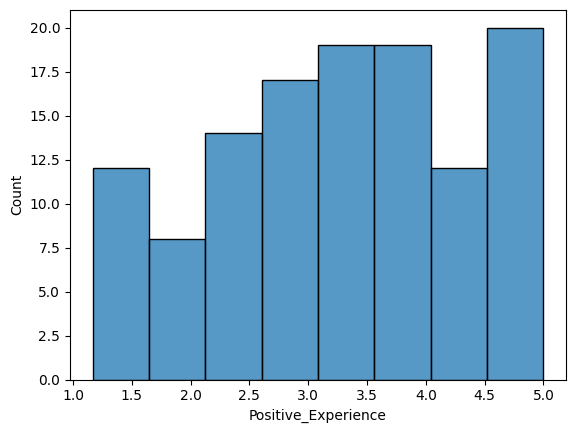

Estatística: 1409.5
Valor p: 0.18015363270320928
Não rejeitamos a hipótese nula - não há evidências suficientes para afirmar diferença nas distribuições dos dados.



In [ ]:
sns.histplot( df_post_games_Q['Positive_Experience'] )
plt.show()

from scipy.stats import mannwhitneyu

df = pd.merge(df_post_games_Q, df_pre_games_Q[['RA','Gênero']], how='inner', on='RA')

stat, p_valor = mannwhitneyu(df[df['Gênero'] == 'Feminino']['Positive_Experience'], df[df['Gênero'] == 'Masculino']['Positive_Experience'])

print("Estatística:", stat)
print("Valor p:", p_valor)
if p_valor < 0.05:
    print("Rejeitamos a hipótese nula - as distribuições dos dados são estatisticamente diferentes.")
else:
    print("Não rejeitamos a hipótese nula - não há evidências suficientes para afirmar diferença nas distribuições dos dados.")
print()

